<a href="https://colab.research.google.com/github/florencianionquepan/analisis_hidratos_offshore/blob/main/An%C3%A1lisis_de_Hidratos_en_L%C3%ADnea_de_Producci%C3%B3n_Offshore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introducción

La formación de hidratos en líneas de producción offshore es un problema crítico en la industria del petróleo y gas. Estas estructuras cristalinas pueden generar bloqueos en las tuberías, afectando la continuidad operativa, aumentando costos de mantenimiento y representando riesgos para la seguridad. Los hidratos se forman bajo condiciones específicas de presión y temperatura, por lo que su monitoreo y control son esenciales para evitar fallas en la producción.

Este proyecto analiza la formación de hidratos en pozos petroleros utilizando el conjunto de datos 3W, que incluye instancias de eventos no deseados en pozos de petróleo, como la formación de hidratos. El dataset contiene información de pozos marinos con flujo natural (no requieren energia adicional), y mide diversas variables de proceso que se monitorizan comúnmente:

* Presión en el PDG
* Presión en el TPT
* Temperatura en el TPT
* Presión aguas arriba del PCK
* Temperatura aguas abajo del PCK

Siendo:
* PDG (Permanent Downhole Gauge): Sensor ubicado en el fondo del pozo que mide la presión.
* TPT (Temperature and Pressure Transducer): Es un dispositivo que contiene sensores de presión y temperatura, y es parte del árbol de navidad submarino
* PCK (Production Choke): Es una válvula de control instalada al principio de la unidad de producción y es responsable del control del pozo en la superficie

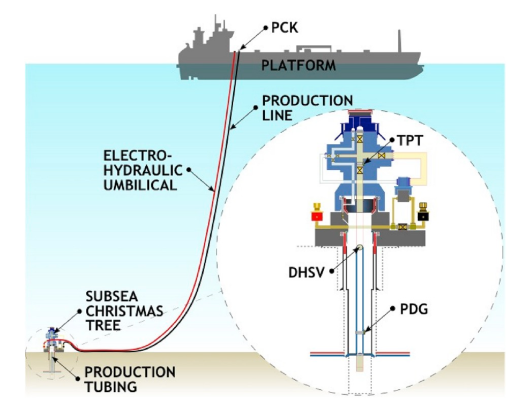


El análisis se centrará en el evento indeseable número 8, "Hidrato en la línea de producción". El conjunto de datos 3W incluye tanto datos reales como simulados, lo que proporciona una base rica para evaluar técnicas de aprendizaje automático para la detección temprana de fallos en ambientes hostiles.

En este trabajo, se analizarán y visualizarán las variables del dataset en histogramas para identificar outliers y se estudiarán los cambios a lo largo del tiempo. Los datos se etiquetan en tres periodos, según el tipo de evento:

* Normal: No se detectan anomalías.
* Faulty Transient (Transitorio Defectuoso): El evento está en curso y aún no ha alcanzado su estado estable.
* Faulty Steady State (Estado Estable Defectuoso): El evento ya ha alcanzado un estado estable.
El etiquetado de los períodos transitorios defectuosos es crucial para la clasificación temprana de los eventos, ya que permite predecir la llegada del **Faulty Steady State**, proporcionando así una alerta temprana para prevenir fallos.

Este conjunto de datos fue presentado en el artículo **Vargas et al. (2019)** y contiene instancias de ocho tipos de eventos indeseables caracterizados por ocho variables de proceso. El trabajo presenta tanto datos reales como simulados, lo que permite entrenar modelos para la detección temprana de fallos y gestionar estos eventos en ambientes hostiles.

### Referencia:
Vargas, R. E., Munaro, C. J., Ciarelli, P. M., Medeiros, A. G., Amaral, B. G., Barrionuevo, D. C., Araújo, J. C. D., Ribeiro, J. L., Magalhães, L. P. (2019). A realistic and public dataset with rare undesirable real events in oil wells. *Journal of Petroleum Science and Engineering*, 181, 106223. [DOI: 10.1016/j.petrol.2019.106223](https://doi.org/10.1016/j.petrol.2019.106223).  
Enlace al artículo completo: [ScienceDirect](http://www.sciencedirect.com/science/article/pii/S0920410519306357).



# Carga del Data set

Se cargan los datos en archivos CSV para trabajar en principio con este formato. Actualmente, el repositorio de Petrobras muestra estos datos en archivos Parquet.

Los archivos Parquet son un formato de almacenamiento optimizado para Big Data, diseñado para ser eficiente en almacenamiento y lectura. Su estructura columnar permite una mejor compresión y acceso más rápido a los datos en comparación con formatos como CSV o JSON, además de ser compatible con herramientas como Apache Spark, Hadoop y Pandas.

Sin embargo, en este trabajo del curso, se utilizan archivos CSV inicialmente para simplificar el procesamiento y manipulación de datos, ya que es un formato más accesible y fácil de manejar sin requerir configuraciones avanzadas o herramientas adicionales.


Desde aqui se dsecomprimio el zip subido:

In [62]:
%reset -f #reseteo de variables
!cp /content/drive/MyDrive/DataScience/Entrega1/8.zip /content/dataset.zip

Don't know how to reset  #reseteo, please run `%reset?` for details
Don't know how to reset  de, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details


In [63]:
!unzip -o /content/dataset.zip -d /content/dataset/


Archive:  /content/dataset.zip
  inflating: /content/dataset/8/SIMULATED_00001.csv  
  inflating: /content/dataset/8/SIMULATED_00002.csv  
  inflating: /content/dataset/8/SIMULATED_00003.csv  
  inflating: /content/dataset/8/SIMULATED_00004.csv  
  inflating: /content/dataset/8/SIMULATED_00005.csv  
  inflating: /content/dataset/8/SIMULATED_00006.csv  
  inflating: /content/dataset/8/SIMULATED_00007.csv  
  inflating: /content/dataset/8/SIMULATED_00008.csv  
  inflating: /content/dataset/8/SIMULATED_00009.csv  
  inflating: /content/dataset/8/SIMULATED_00010.csv  
  inflating: /content/dataset/8/SIMULATED_00011.csv  
  inflating: /content/dataset/8/SIMULATED_00012.csv  
  inflating: /content/dataset/8/SIMULATED_00013.csv  
  inflating: /content/dataset/8/SIMULATED_00014.csv  
  inflating: /content/dataset/8/SIMULATED_00015.csv  
  inflating: /content/dataset/8/SIMULATED_00016.csv  
  inflating: /content/dataset/8/SIMULATED_00017.csv  
  inflating: /content/dataset/8/SIMULATED_00018.csv

Para familiarizarse con los datos a analizar, se cargarán todos los archivos CSV en dataframes. Según la documentación revisada, todos los CSV contienen las mismas columnas y, de acuerdo con las reglas establecidas, deben ser considerados en conjunto para un análisis adecuado. En esta etapa, se verificará que todos los archivos mantengan la misma estructura y se describirá el significado de cada columna.

In [64]:
import pandas as pd
import os
import re

data_path='/content/dataset/8'

dfs = {}  # Diccionario para almacenar los DataFrames

# Obtener todos los archivos CSV en la carpeta
files = [file for file in os.listdir(data_path) if file.endswith(".csv")]

# Separar los archivos en listas distintas
simulated_files = sorted(
    [file for file in files if file.startswith("SIMULATED")],
    key=lambda x: int(re.search(r'\d+', x).group())  # Extraer número y ordenar
)

well_files = sorted(
    [file for file in files if file.startswith("WELL") or file.startswith("WEL")],
    key=lambda x: int(re.search(r'\d+', x).group())  # Extraer número y ordenar
)

# Unir las listas con SIMULATED primero y WELL después
sorted_files = simulated_files + well_files

# Cargar los archivos en el diccionario ordenado
for file in sorted_files:
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)
    dfs[file] = df  # Guardar el DataFrame con su nombre de archivo

print(f"Se cargaron {len(dfs)} archivos CSV.")

# Verificar el primer y último archivo en el diccionario
first_file = next(iter(dfs))
last_file = list(dfs.keys())[-1]

print(f"\n📂 Primer archivo en el diccionario: {first_file}")
print(f"📂 Último archivo en el diccionario: {last_file}")

for file, df in dfs.items():
    print(f"\n📂 Archivo: {file}")
    print(df.columns.tolist())  # Lista de nombres de columnas
    print(df.dtypes)  # Verifica el tipo de datos de cada columna

Se cargaron 84 archivos CSV.

📂 Primer archivo en el diccionario: SIMULATED_00001.csv
📂 Último archivo en el diccionario: WELL-00021_20170509013517.csv

📂 Archivo: SIMULATED_00001.csv
['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL', 'class']
timestamp      object
P-PDG         float64
P-TPT         float64
T-TPT         float64
P-MON-CKP     float64
T-JUS-CKP     float64
P-JUS-CKGL    float64
T-JUS-CKGL    float64
QGL           float64
class           int64
dtype: object

📂 Archivo: SIMULATED_00002.csv
['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL', 'class']
timestamp      object
P-PDG         float64
P-TPT         float64
T-TPT         float64
P-MON-CKP     float64
T-JUS-CKP     float64
P-JUS-CKGL    float64
T-JUS-CKGL    float64
QGL           float64
class           int64
dtype: object

📂 Archivo: SIMULATED_00003.csv
['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-C

Como se puede ver, todos los csvs contienen los mismos nombres de columnas:


1. timestamp: Marca de tiempo que indica el momento exacto en que se registró cada medición. Está en formato "AAAA-MM-DD HH:MM:SS.ssssss" (año-mes-día hora:minuto:segundo.milisegundos), lo que permite un análisis temporal preciso de los datos
2. P-PDG: Presión del fluido en el PDG [Pa]
3. P-TPT: Presión del fluido en el TPT [Pa]
4. T-TPT:  Temperatura del fluido en el TPT [C]
5. P-MON-CKP: Presión del fluido antes de la válvula PCK, o lo que es lo mismo, presión aguas arriba de la válvula PCK [Pa]
6. T-JUS-CKP: Temperatura del fluido después de la válvula o aguas abajo del PCK [C]
7. P-JUS-CKGL: Presión del fluido después de la válvula de control de gas lift [Pa]
8. T-JUS-CKGL:  Temperatura del fluido después de la válvula de control de gas lift [C]
9. QGL: Caudal de gas lift [sm3/s]
10. class: Etiqueta que indica el estado del sistema en cada registro. Puede tomar diferentes valores, 0: Estado normal, sin anomalias. 3 y 103: eventos anomales detectados. De todas maneras, no se encontro aun ninguna referencia a estos codigos especificos.



# Exploración y visualización (EDA): conociendo el data set

Dado que se cuenta con las mismas columnas en todos los archivos, se exploraran algunas filas y dimensiones de un archivo en especifico:

In [65]:
# Obtener la primera clave del diccionario (que es el nombre del archivo)
first_file = next(iter(dfs))

# Acceder al DataFrame correspondiente a ese archivo
df_1 = dfs[first_file]

print(f"\n📂 Primer archivo en el diccionario: {first_file}")

# Primeras filas
print("\nPrimeras filas:")
print(df_1.head())

# Últimas filas
print("\nÚltimas filas:")
print(df_1.tail())

# Dimensiones del DataFrame
print("\nDimensiones (filas, columnas):")
print(df_1.shape)

# Información general sobre el DataFrame
print("\nInformación general sobre el DataFrame:")
print(df_1.info())

# Columnas del DataFrame
print("\nColumnas del DataFrame:")
print(df_1.columns.tolist())


📂 Primer archivo en el diccionario: SIMULATED_00001.csv

Primeras filas:
                    timestamp       P-PDG       P-TPT  T-TPT  P-MON-CKP  \
0  2018-05-17 22:56:06.000000 27897490.00 19824230.00 125.69 4059666.00   
1  2018-05-17 22:56:07.000000 27897450.00 19824230.00 125.69 4059666.00   
2  2018-05-17 22:56:08.000000 27897360.00 19824230.00 125.69 4059666.00   
3  2018-05-17 22:56:09.000000 27897430.00 19824230.00 125.69 4059666.00   
4  2018-05-17 22:56:10.000000 27897500.00 19824230.00 125.69 4059666.00   

   T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
0      97.55         NaN         NaN  NaN      0  
1      97.55         NaN         NaN  NaN      0  
2      97.55         NaN         NaN  NaN      0  
3      97.55         NaN         NaN  NaN      0  
4      97.55         NaN         NaN  NaN      0  

Últimas filas:
                        timestamp       P-PDG       P-TPT  T-TPT  P-MON-CKP  \
26994  2018-05-18 06:26:00.000000 33700360.00 28074090.00   3.41 4002707.0

Las columnas P-JUS-CKGL, T-JUS-CKGL y QGL están asociadas al sistema de gas lift, el cual no está presente en los conjuntos de datos analizados (todas sus entradas son NaN). Además, el gas lift no tiene un impacto directo en la formación de hidratos, ya que este fenómeno está determinado principalmente por las condiciones de presión y temperatura en el fondo del pozo, así como por la caída de presión en el PCK. Dado que estas variables no aportan información relevante para este análisis y su presencia solo introduciría datos faltantes, se justifica su eliminación del estudio.

In [66]:
for file, df in dfs.items():
    # Borrar las columnas relacionadas con gas lift
    columns_to_drop = ['P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

## Analisis de medidas estadisticas

A continuacion se visualizaran las principales medidas estadisticas de cada archivo.

In [67]:
pd.set_option('display.float_format', '{:.2f}'.format) # Para ver numeros sin notacion cientifica y ver valores mas claros

for file in sorted(dfs.keys()):
    df = dfs[file]
    print(f"\n📂 Archivo: {file}")
    # Convertir la columna 'class' a string
    if 'class' in df.columns:
        df['class'] = df['class'].astype(str)

    # Convertir a MPa si las columnas existen
    if "P-PDG" in df.columns:
        df["P-PDG (MPa)"] = df["P-PDG"] / 1e6  # Convertir a MPa
    if "P-TPT" in df.columns:
        df["P-TPT (MPa)"] = df["P-TPT"] / 1e6  # Convertir a MPa
    if "P-MON-CKP" in df.columns:
        df["P-MON-CKP (MPa)"] = df["P-MON-CKP"] / 1e6  # Convertir a MPa

    print(df["T-JUS-CKP"].isna().sum())  # Muestra cuántos NaN hay en la columna de T-JUS-CKP

    # Definir el orden deseado de columnas a mostrar
    columnas_a_mostrar = ["T-TPT", "P-TPT (MPa)", "P-MON-CKP (MPa)", "T-JUS-CKP", "P-PDG (MPa)"]

    # Filtrar y reordenar solo las columnas disponibles
    columnas_presentes = [col for col in columnas_a_mostrar if col in df.columns]

    # Mostrar estadísticas solo de estas columnas
    print(df.loc[:, columnas_presentes].describe())


📂 Archivo: SIMULATED_00001.csv
0
         T-TPT  P-TPT (MPa)  P-MON-CKP (MPa)  T-JUS-CKP  P-PDG (MPa)
count 26999.00     26999.00         26999.00   26999.00     26999.00
mean     21.26        26.98             4.01      50.28        32.96
std      41.87         2.69             0.02      24.78         1.89
min       3.12        19.82             4.00      27.83        27.90
25%       3.41        27.71             4.00      32.45        33.66
50%       3.42        28.10             4.00      36.63        33.70
75%       3.55        28.16             4.00      63.98        33.70
max     126.16        28.21             4.06      97.55        33.74

📂 Archivo: SIMULATED_00002.csv
0
         T-TPT  P-TPT (MPa)  P-MON-CKP (MPa)  T-JUS-CKP  P-PDG (MPa)
count 26999.00     26999.00         26999.00   26999.00     26999.00
mean     21.09        27.29             4.01      47.69        32.99
std      41.47         2.62             0.02      22.14         1.91
min       3.21        20.26        

Se estudiarán entonces las siguientes variables: T-TPT, P-TPT, P-MON-PCK, T-JUS-PCK y P-PDG.

### Análisis de los datos simulados

En los archivos de datos simulados, específicamente en el primer archivo, se observa lo siguiente:

T-TPT: La media y la mediana presentan una diferencia significativa, lo que sugiere una distribución asimétrica. La media es de 21.26°C y la mediana de 3.42°C. Dado que la media es mayor que la mediana, esto indica una asimetría positiva, es decir, una cola larga a la derecha, lo que sugiere que existen valores muy altos que están elevando la media.

P-TPT: En este caso, la media y la mediana son muy similares, con valores de 26.98 MPa y 28.10 MPa, respectivamente, lo que indica una distribución simétrica.

P-MON-PCK (presión aguas arriba del PCK): La media es de 4.01 MPa y la mediana de 4 MPa, lo que también sugiere una distribución simétrica.

T-JUS-CKP (temperatura aguas abajo del PCK): La media es de 50°C y la mediana de 36.63°C, lo que indica una distribución asimétrica y que existen valores muy altos que están elevando la media.

P-PDG (presión en el manómetro): La media es de 32.96 MPa y la mediana de 33.70 MPa, mostrando valores muy similares entre sí, lo que refleja una distribución simétrica.

En este contexto, tiene sentido que la desviación estándar sea más alta en las mediciones de temperatura (debido a la asimetría y los valores extremos) y más baja en las mediciones de presión (que presentan distribuciones más simétricas).

Para el resto de los archivos CSV de tipo simulados, los valores tienden a mantenerse consistentes con los observados en el primer archivo.

A continuación, se mostrarán los histogramas de estas mismas variables para verificar si las conclusiones obtenidas son correctas. En un primer intento, se utilizó la regla de la raíz cuadrada para determinar el número de intervalos (lo que dio como resultado 164 intervalos, equivalente a la raíz cuadrada de las 26,999 observaciones), pero los valores de algunas variables aparecian muy concentrados solamente en algunos intervalos.


Luego se decidio obtener el numero de intervalos con la Regla de Scott que es mas apropiada para variables que presentan valores atipicos, ya que con una frecuencia fija se veian muchos valores en los extremos. La Regla de Scott sugiere que el ancho de cada intervalo debe ser igual a 3.5 veces la desviación estándar dividido por la raíz cuadrada del número de observaciones.
Inmediatamente debajo se visualizaran tambien los graficos de caja boxplot.

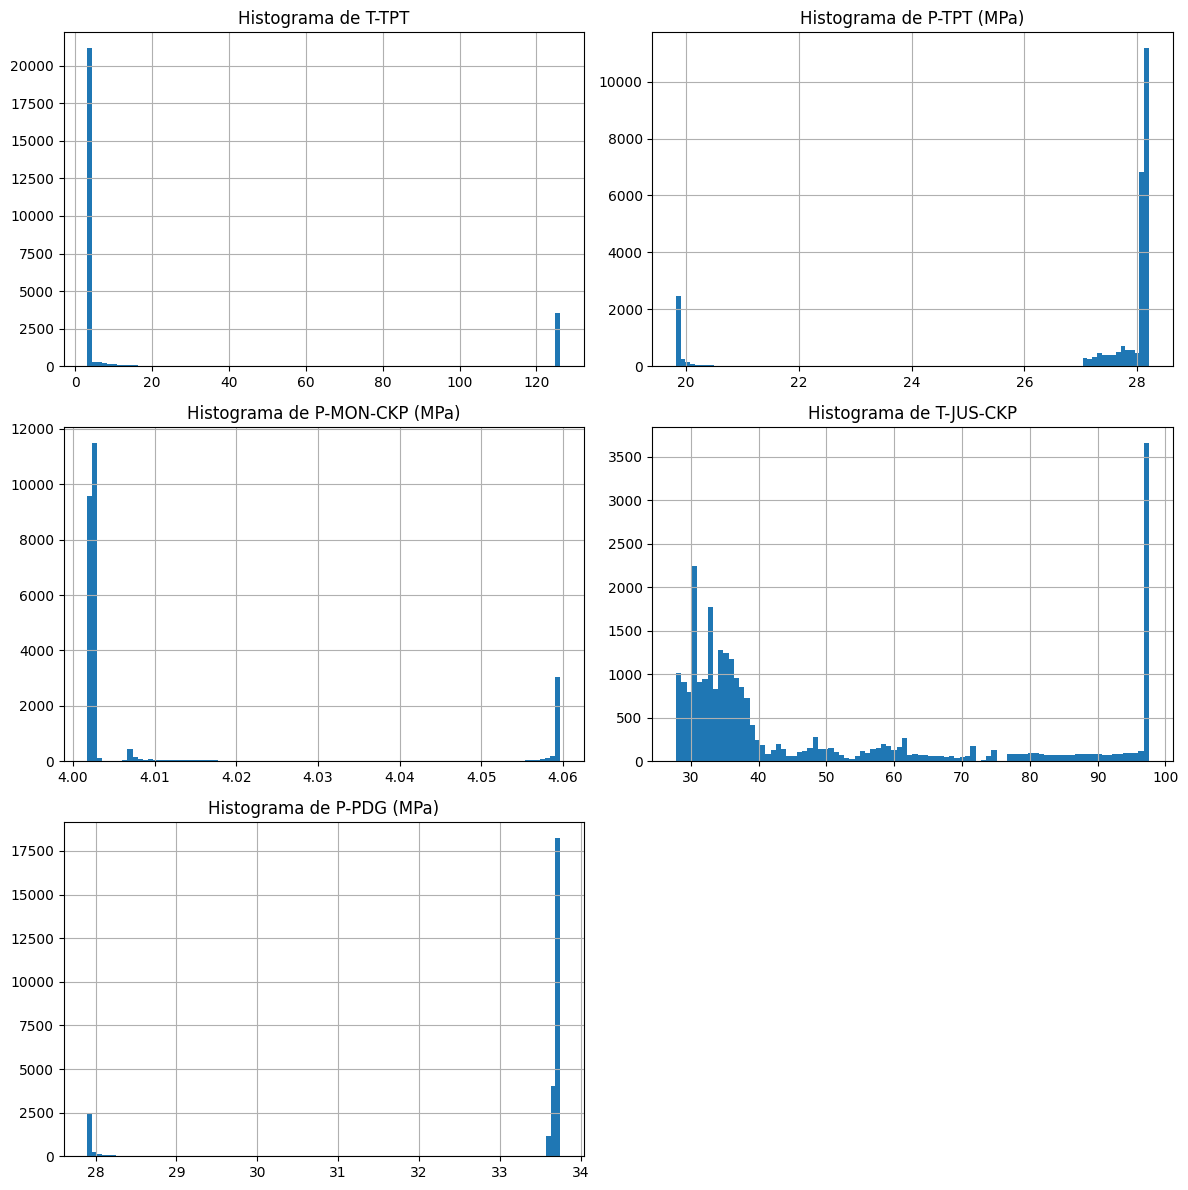

In [68]:
import matplotlib.pyplot as plt
import numpy as np

file_simulated_1='SIMULATED_00001.csv'
df_simulated_1=dfs[file_simulated_1]
n=12699

variables = ["T-TPT", "P-TPT (MPa)", "P-MON-CKP (MPa)", "T-JUS-CKP", "P-PDG (MPa)"]

intervalos_scott = {}

# Calcular el intervalo de Scott para cada variable
for var in variables:
    std = df_simulated_1[var].std()  # Desviación estándar de la variable
    intervalo_scott = (3.5 * std) / np.sqrt(n)
    intervalos_scott[var] = intervalo_scott

# Graficar los histogramas
plt.figure(figsize=(12, 12))

for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)  # Distribuir los gráficos en una cuadrícula 3x2
    intervalo_scott = intervalos_scott[var]  # Obtener el intervalo de Scott para la variable
    bins = int((df_simulated_1[var].max() - df_simulated_1[var].min()) / intervalo_scott)  # Calcular el número de bins
    df_simulated_1[var].hist(bins=bins)
    plt.title(f'Histograma de {var}')

plt.tight_layout()  # Ajustar automáticamente los espacios entre gráficos
plt.show()

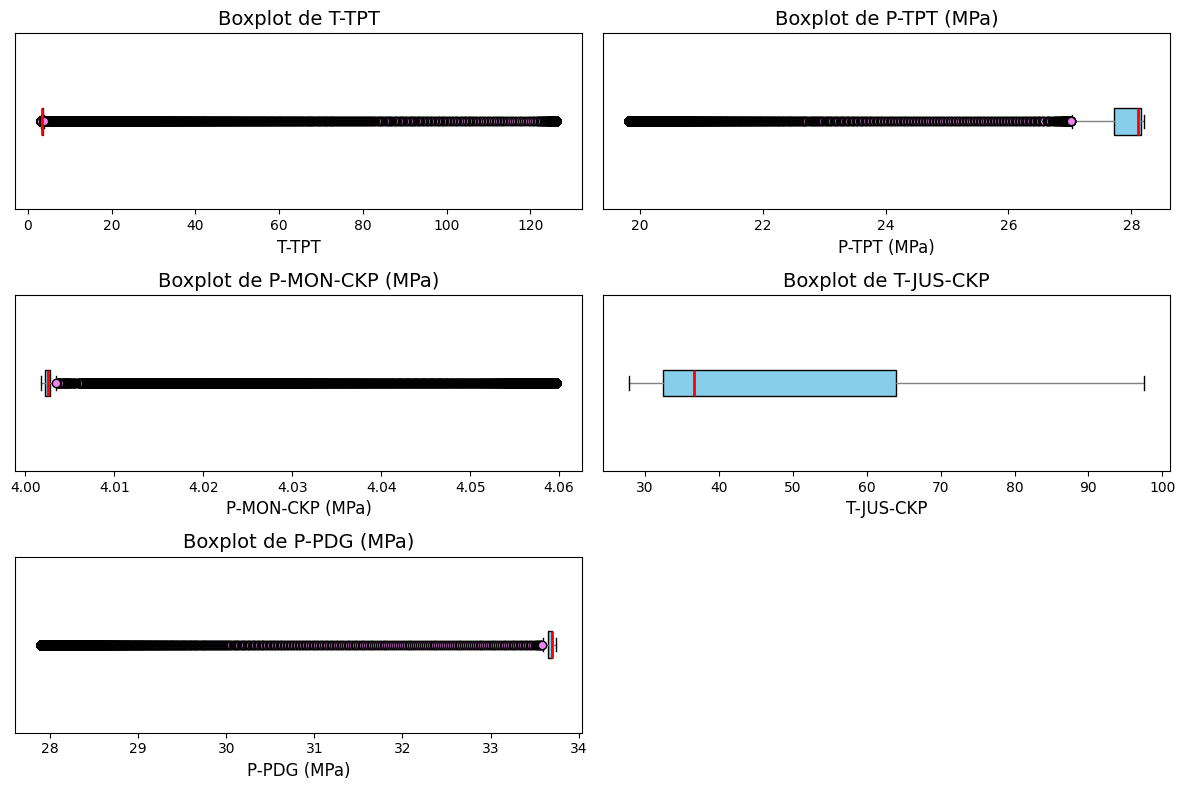

In [69]:
# Graficar los boxplots
plt.figure(figsize=(12, 8))

# Definir propiedades para los outliers (más personalizable)
flierprops = dict(marker='o', markerfacecolor='violet', markersize=6, linestyle='none', markeredgecolor='black')
for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)
    boxplot_parts = plt.boxplot(df_simulated_1[var], vert=False, flierprops=flierprops, patch_artist=True)

    # boxprops para el color de la caja
    boxplot_parts['boxes'][0].set(facecolor='skyblue', edgecolor='black')  # Color de la caja y borde

    # whiskerprops para el color de los "bigotes"
    for whisker in boxplot_parts['whiskers']:
        whisker.set(color='gray')

    # medianprops para el color y grosor de la mediana
    for median in boxplot_parts['medians']:
        median.set(color='red', linewidth=2)

    plt.title(f'Boxplot de {var}', fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.yticks([])

plt.tight_layout()
plt.show()

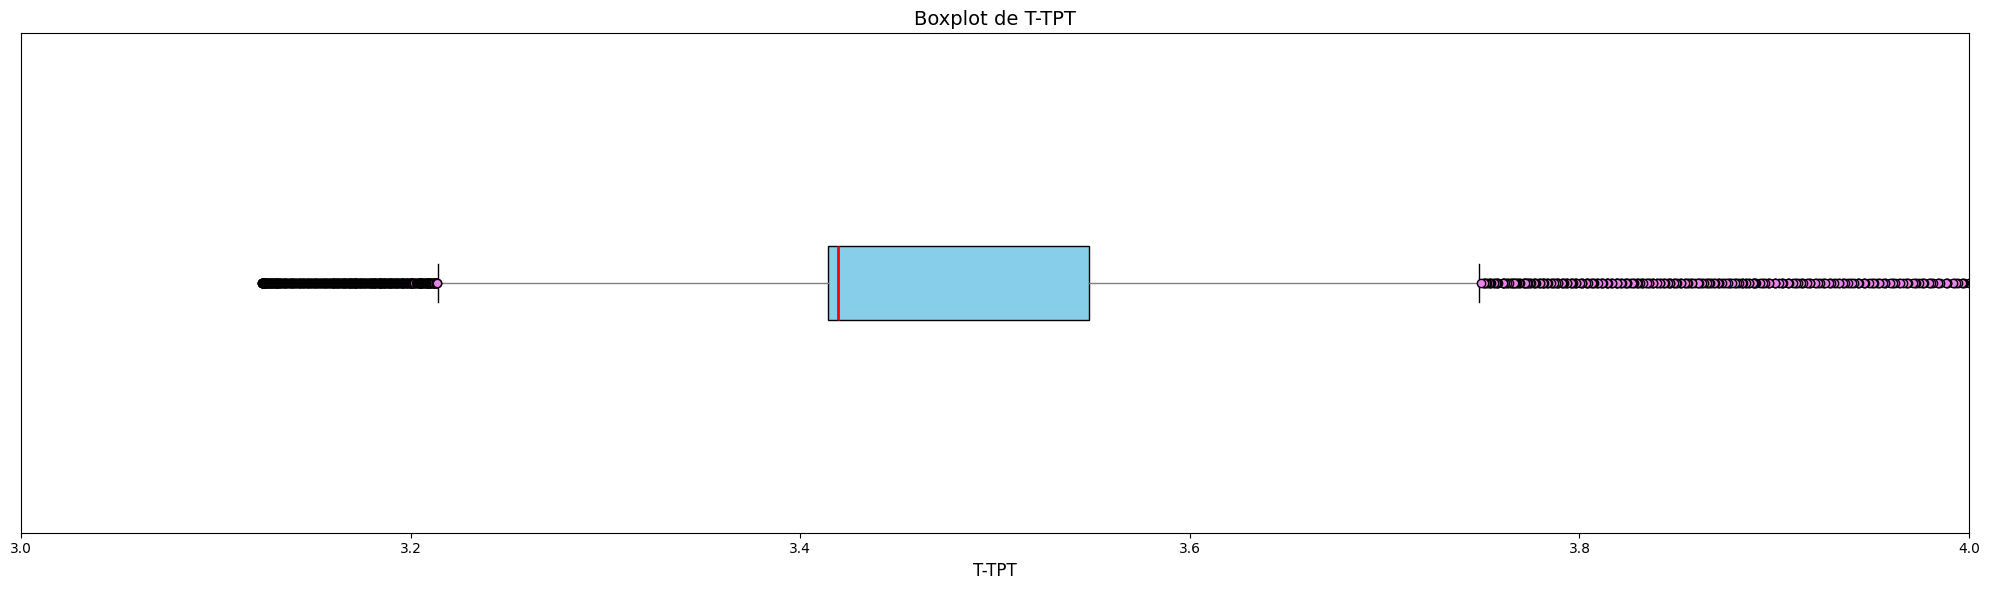

In [70]:
# Grafico de nuevo el boxplot de T-TPT con otro tamaño y cortando los outliers porque debo visualizar la caja
plt.figure(figsize=(20, 6))  # Ajustar tamaño de la figura si es necesario

# Definir propiedades para los outliers
flierprops = dict(marker='o', markerfacecolor='violet', markersize=6, linestyle='none', markeredgecolor='black')

boxplot_parts = plt.boxplot(df_simulated_1['T-TPT'], vert=False, flierprops=flierprops, patch_artist=True)

# Estilos para la caja, bigotes y mediana (como antes)
boxplot_parts['boxes'][0].set(facecolor='skyblue', edgecolor='black')
for whisker in boxplot_parts['whiskers']:
    whisker.set(color='gray')
for median in boxplot_parts['medians']:
    median.set(color='red', linewidth=2)

plt.title('Boxplot de T-TPT', fontsize=14)
plt.xlabel('T-TPT', fontsize=12)
plt.yticks([])  # Ocultar ticks del eje Y

# Ajustar la escala horizontal (eje X)
plt.xlim(3, 4)  # Ajusta los límites según tus datos

plt.tight_layout()
plt.show()

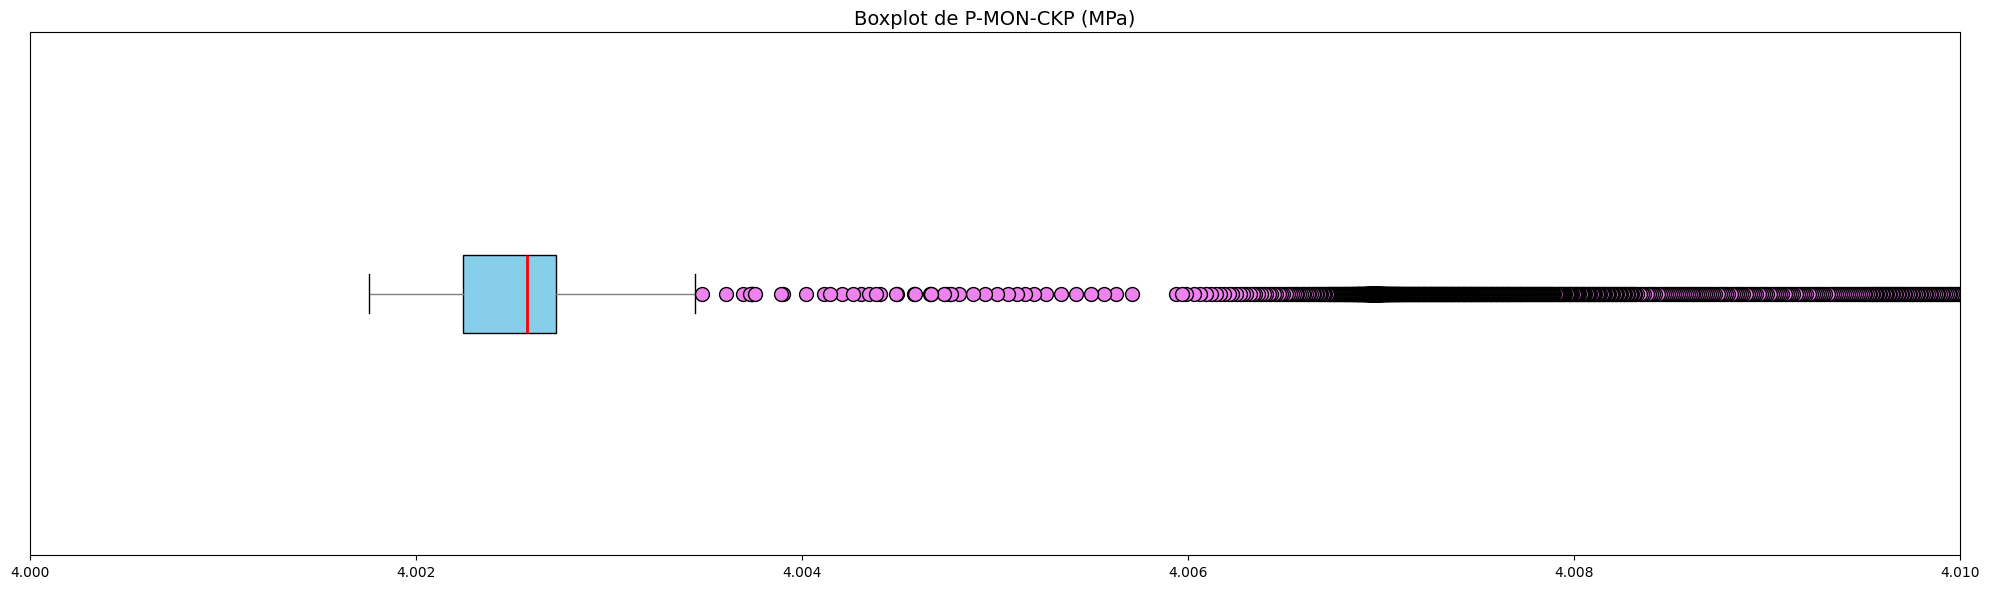

In [71]:
# Grafico de nuevo el boxplot de P-MON-CKP con otro tamaño y cortando los outliers porque debo visualizar la caja
plt.figure(figsize=(20, 6))  # Ajustar tamaño de la figura si es necesario

# Definir propiedades para los outliers
flierprops = dict(marker='o', markerfacecolor='violet', markersize=10, linestyle='none', markeredgecolor='black')

boxplot_parts = plt.boxplot(df_simulated_1['P-MON-CKP (MPa)'], vert=False, flierprops=flierprops, patch_artist=True)

# Estilos para la caja, bigotes y mediana (como antes)
boxplot_parts['boxes'][0].set(facecolor='skyblue', edgecolor='black')
for whisker in boxplot_parts['whiskers']:
    whisker.set(color='gray')
for median in boxplot_parts['medians']:
    median.set(color='red', linewidth=2)

plt.title('Boxplot de P-MON-CKP (MPa)', fontsize=14)
plt.yticks([])  # Ocultar ticks del eje Y

# Ajustar la escala horizontal (eje X)
plt.xlim(4, 4.01)  # Ajusta los límites según tus datos

plt.tight_layout()
plt.show()

En cuanto a la variable **T-TPT**, el **histograma** sugiere que los valores se concentran más en los extremos que en el centro, con una mayor frecuencia de temperaturas bajas en comparación con las altas. Este patrón es consistente con la asimetría positiva previamente indicada por la media mayor a la mediana (cola larga a la derecha). Es decir, existen valores muy altos (outliers o valores atípicos) que están elevando la media. Aunque las temperaturas bajas son más frecuentes, los valores extremos elevados, aunque pocos, son lo suficientemente grandes como para desplazar la media hacia valores más altos, lo que refuerza la presencia de una asimetría positiva en la distribución.
Al observar el **boxplot**, se pueden ver varios outliers de temperaturas altas. La caja se extiende desde aproximadamente 3.4 hasta 3.55, lo que indica que el 50% central de los datos de T-TPT se encuentra en este rango. La línea de la mediana está ligeramente más cerca del borde inferior de la caja, lo que sugiere una asimetría hacia los valores más altos. Además, varios puntos atípicos se encuentran por encima del bigote superior, lo que confirma la presencia de valores inusualmente altos en los datos.

El análisis del **histograma de P-TPT** revela una distribución peculiar, con una concentración significativa de valores en los extremos. Se observan picos prominentes alrededor de 20 MPa y, especialmente, en 28 MPa.
El **boxplot** complementa esta visión mostrando una dispersión considerable de los datos, con una mediana ubicada cerca del tercer cuartil (Q3). La presencia de varios outliers por debajo del límite inferior sugiere la existencia de valores inusualmente bajos de P-TPT que podrían merecer una investigación más profunda. La ausencia de outliers por encima del límite superior indica que no hay valores extremadamente altos que se desvíen significativamente del resto de la distribución.

---

El **histograma de presion aguas arriba P-MON-PCK** revela una distribución con una alta frecuencia de valores centrados en 4 y 4.06 MPa. Esta concentración de valores sugiere una posible distribución simétrica, aunque con una ligera asimetría positiva (cola hacia la derecha).
El **boxplot** complementa esta información mostrando una dispersión considerable de los datos, con una mediana ligeramente desplazada hacia el tercer cuartil (Q3). La presencia de varios outliers por encima del límite superior indica la existencia de valores inusualmente altos de P-MON-PCK que se desvían significativamente del resto de la distribución. Estos outliers podrían brindar información relevante sobre el sistema en estudio por lo que no se van a descartar.


El **histograma de la temperatura aguas abajo (T-JUS-CKP)** revela una dispersión considerable de los datos. Si bien la media se sitúa en 50°C y la mediana en 36.63°C, esta diferencia sugiere una distribución asimétrica, con valores extremos que elevan la media. En efecto, se observan picos de temperatura significativamente altos, mientras que la mayoría de los datos se concentran en valores más bajos, entre 30 y 40°C.
El **boxplot** confirma esta asimetría y dispersión, mostrando una distribución donde no se identifican outliers. Esto implica que, si bien existen valores altos de temperatura, estos no se consideran atípicos según el criterio del boxplot.

---

Los **valores de presión en el manómetro (P-PDG)** se concentran frecuentemente entre 33 y 34 MPa, lo que sugiere un rango típico de operación del sistema. Sin embargo, se identifican algunos outliers en 28 MPa, lo que indica la presencia de eventos o condiciones inusuales que resultan en presiones más bajas. Estos outliers podrían indicar información relevante sobre el sistema en estudio.




### Análisis de los datos reales

En el archivo correspondiente al pozo WELL-00019, se observan las siguientes características:

T-JUS-CKP: En este caso, las medidas estadísticas son todas NaN. Al verificar contra el archivo CSV original, se confirma que esta columna no contiene ningún valor en dicho archivo.

Presiones: Para las demás variables de presión, los valores resultan ser 0, ya que todos los registros en este archivo contienen 0 en esas columnas.

P-MON-CKP: Esta variable presenta una media de 1.40 MPa y una mediana de 1.18 MPa, con un valor máximo de 3.15 MPa. Además, la desviación estándar es muy pequeña, lo que sugiere una distribución bastante estable. Este comportamiento se mantiene en los archivos de los otros dos pozos, WELL-00020 y WELL-00021, donde los datos de esta variable son consistentes y presentan medidas estadísticas similares.

Para el pozo WELL-00020:

T-TPT: La media es de 21°C, mientras que la mediana es de 14.97°C, con una desviación estándar de 14°C. Esto indica que podría tratarse de una distribución asimétrica.

P-TPT: La media es de 1378.7 MPa y la mediana de 1405.1 MPa. Dado que la media y la mediana son bastante similares, no parece haber una desviación asimétrica significativa en esta variable.

P-MON-CKP: La media es de 2.97 MPa y la mediana de 3.15 MPa, lo que indica una distribución simétrica.

T-JUS-CKP: No se encuentran valores en este pozo.

P-PDG (presión en el manómetro): La media es de 2254 MPa y la mediana de 2262 MPa, con valores bastante cercanos, lo que sugiere una distribución simétrica.

Una observación importante es la diferencia entre las presiones reales y las de los datos simulados. Esto podría deberse a la naturaleza de los modelos de simulación, que no siempre replican con precisión las condiciones reales del pozo. Es recomendable investigar este aspecto para comprender mejor las discrepancias.

Para el pozo WELL-00021:

T-TPT: La media es de 13°C y la mediana de 16°C, con una desviación estándar de 5.47°C. Esto indica una distribución con ligera asimetría, pero los valores no parecen estar excesivamente dispersos.

P-TPT: La media es de 1448 MPa y la mediana de 1648 MPa, lo que sugiere que podrían existir outliers (valores extremos), ya que la diferencia entre la media y la mediana es considerable. El valor máximo observado en esta columna es de 1979 MPa, lo que refuerza la hipótesis de la presencia de valores atípicos.

P-MON-CKP: La media es de 1.42 MPa y la mediana de 1.33 MPa, lo que indica que los valores se mantienen cercanos, sugiriendo una distribución simétrica.

T-JUS-CKP: No contiene valores en este pozo.

P-PDG: La media es de 3085 MPa y la mediana de 3084 MPa, lo que indica que esta variable no presenta fluctuaciones importantes en este pozo.

Conclusiones finales:

En los datos de los pozos WELL-00019 y WELL-00020, los valores de temperatura y presión parecen seguir patrones consistentes, aunque se observan algunas columnas con valores faltantes, como es el caso de T-JUS-CKP. Por otro lado, las presiones de los pozos reales, en particular P-TPT y P-MON-CKP, muestran una estabilidad que podría sugerir una distribución simétrica en su mayoría. Sin embargo, en el pozo WELL-00021, la presencia de outliers en P-TPT requiere una atención especial, ya que estos valores atípicos podrían influir en la interpretación del comportamiento de las presiones.


---

Haremos uso de los histogramas para vsualizar la informacion real de los pozos WELL-00020 y WEL-00021 y en este caso se analizaran de forma mas resumida los datos. Luego se procederá con la evaluación mediante boxplots para identificar los outliers en caso de ser necesario. Este análisis no tiene como objetivo eliminar ni descartar los datos, sino que sera util para luego identificar los timestamps correspondientes a los valores atípicos y analizar su posible relación con la formación de hidratos. Este enfoque permitirá evaluar si existe un patrón entre la presencia de valores atípicos y las condiciones que favorecen la formación de hidratos.



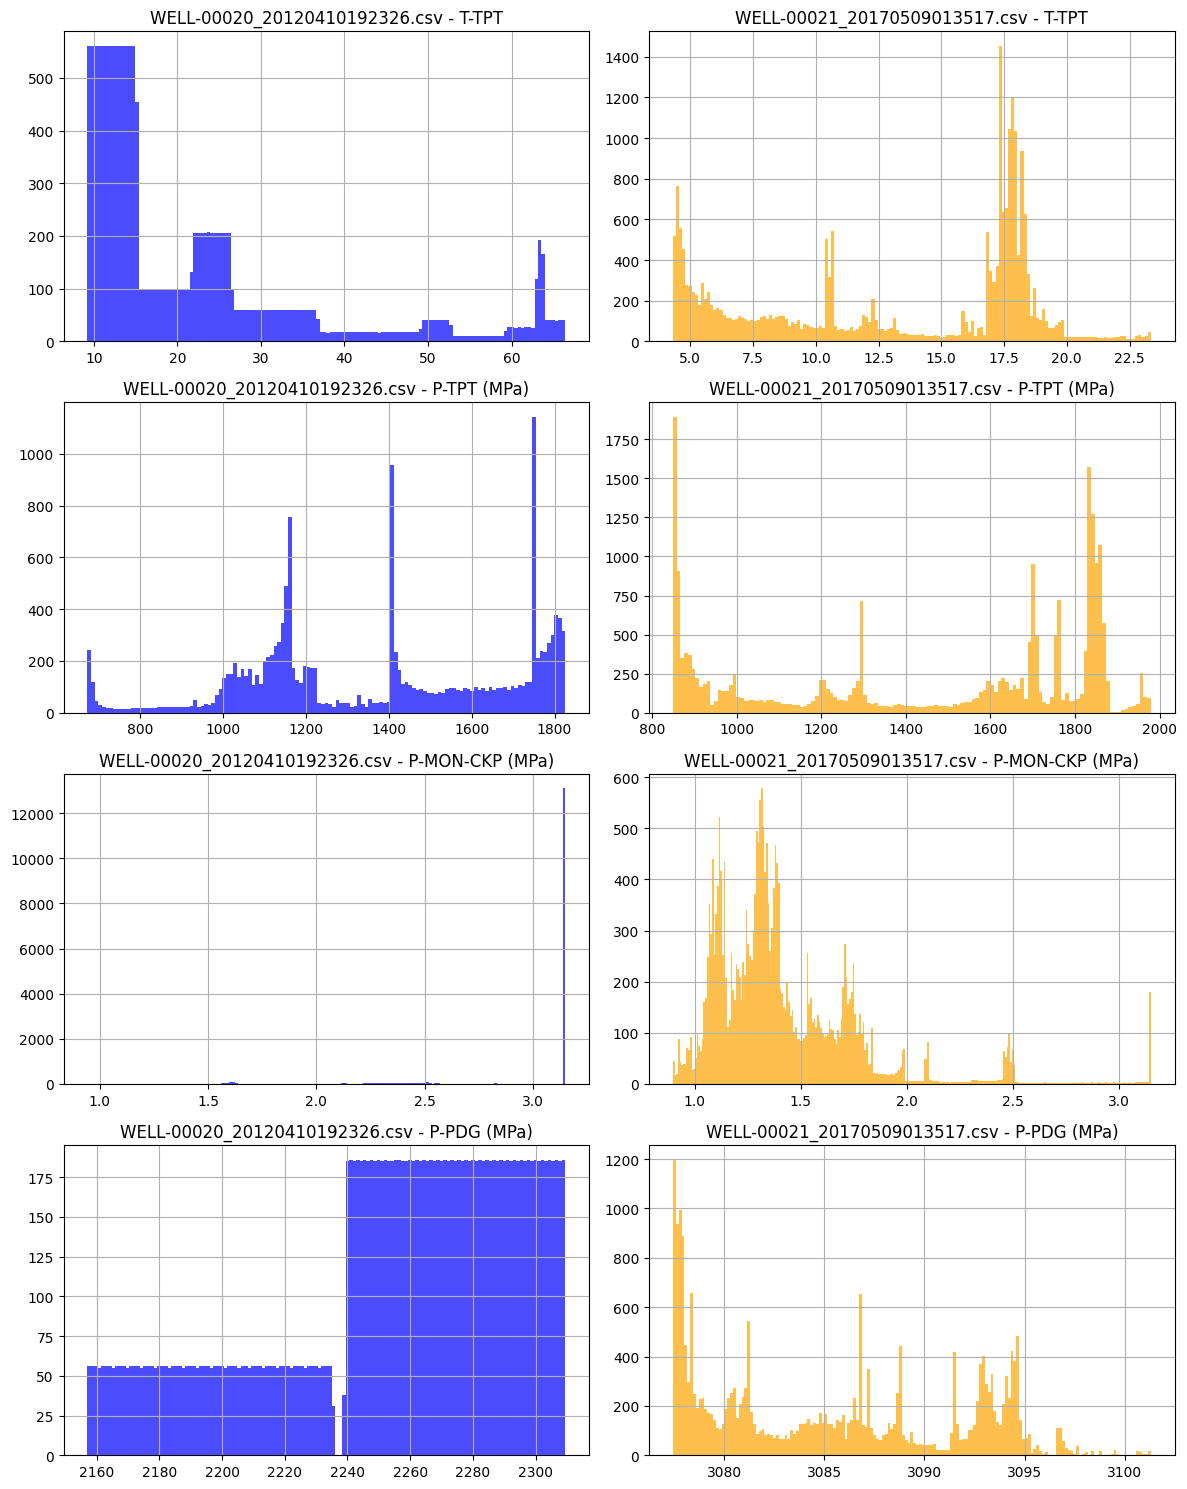

In [72]:
import matplotlib.pyplot as plt
import numpy as np

file_well_20='WELL-00020_20120410192326.csv'
file_well_21='WELL-00021_20170509013517.csv'
df_well_20=dfs[file_well_20]
df_well_21=dfs[file_well_21]

files_selected= {file_well_20: df_well_20, file_well_21: df_well_21 }

variables = ["T-TPT", "P-TPT (MPa)", "P-MON-CKP (MPa)", "P-PDG (MPa)"] # No analizamos de aca T-JUS-CKP porque no tiene valores
# Diccionario para almacenar los intervalos de Scott
intervalos_scott = {file: {} for file in files_selected}

# Calcular el intervalo de Scott para cada variable en cada archivo
for file_name, dff in files_selected.items():
    n = len(dff)  # Cantidad de datos
    for var in variables:
        std = dff[var].std()  # Desviación estándar de la variable
        intervalo_scott = (3.5 * std) / np.sqrt(n)  # Cálculo del intervalo de Scott
        intervalos_scott[file_name][var] = intervalo_scott  # Guardar en el diccionario

# Graficar los histogramas comparando ambos archivos
fig, axes = plt.subplots(len(variables), 2, figsize=(12, 15))  # Dos columnas para comparar

for i, var in enumerate(variables):
    for j, (file_name, dff) in enumerate(files_selected.items()):
        ax = axes[i, j]  # Selecciona la posición en la cuadrícula
        intervalo_scott = intervalos_scott[file_name][var]  # Obtener el intervalo de Scott
        bins = int((dff[var].max() - dff[var].min()) / intervalo_scott)  # Calcular el número de bins
        dff[var].hist(bins=bins, ax=ax, alpha=0.7, color="blue" if j == 0 else "orange")
        ax.set_title(f'{file_name} - {var}')

plt.tight_layout()  # Ajustar automáticamente los espacios entre gráficos
plt.show()

En general, se observa que los datos reales no presentan valores atípicos en comparación con los datos simulados, salvo en el caso de la presión P-MON-CKP en el pozo WELL-00020.
Analizando cada variable en detalle:

Temperatura en el transductor T-TPT:

En el pozo WELL-00021, la mayoría de los valores se encuentran entre 10 y 30°C, con una media de 21°C y algunos registros alrededor de 60°C. Debido a la presencia de estos valores altos, la mediana es menor que la media (15°C).
En el pozo WELL-00020, los valores de temperatura son generalmente más bajos, con una media de 13°C y una mayor concentración de datos en torno a 18°C, lo que explica que la mediana sea ligeramente mayor (16°C).

Presión en el transductor P-TPT:

En el pozo WELL-00020, se observan tres picos pronunciados en 1800 MPa, 1400 MPa y 1750 MPa. (Esto sera importante tenerlo en cuenta a la hora de graficar estos valores vs la etiqueta del evento no deseado de la formacion de hidratos)
En el pozo WELL-00021, destaca un pico muy pronunciado en 850 MPa, además de otros menos marcados en 1700 MPa y 1900 MPa.

Presion aguas abajo del CKP P-MON-CKP:

La P-MON-CKP en el pozo WELL-00020 presenta la mayor frecuencia de valores en 3 MPa, mientras que el resto se distribuye en valores más bajos. Se muestra mas abajo su boxplot para identificar estos outliers.

En el pozo WELL-00021, la distribución de valores es más amplia, lo que concuerda con su media de 1.42 MPa y mediana de 1.33 MPa. Se verifico con su boxplot que poseen algunos outliers altos, pero en esta instancia no se ve una relacion directa con la formacion de hidratos.

Presion manometro PDG:

Por otro lado, la presión en el manómetro PDG en el pozo WELL-00020 sugiere que, durante el mismo período de tiempo (55 ocurrencias), la presión se mantuvo en distintos valores entre 2160 y 2235 MPa. Se sospecha que durante un periodo de tiempo constante, la presion iba variando y se mantenia el mismo periodo de tiempo en distintos valores. Posteriormente, la presión comienza a aumentar, alcanzando 2240 MPa, ahora manteniendose por mayor periodo de tiempo pero constante nuevamente, hasta 2300 Mpa. Esto sera evaluado luego al graficar versus el tiempo esta variable. Tambien es interesante que en esta variable para este pozo no se pudo graficar el boxplot con el mismo algoritmo que se urilizo en todos los casos.

En el pozo WELL-00021, se registran picos de presión superiores a 3075 MPa, alcanzando hasta 3100 MPa.

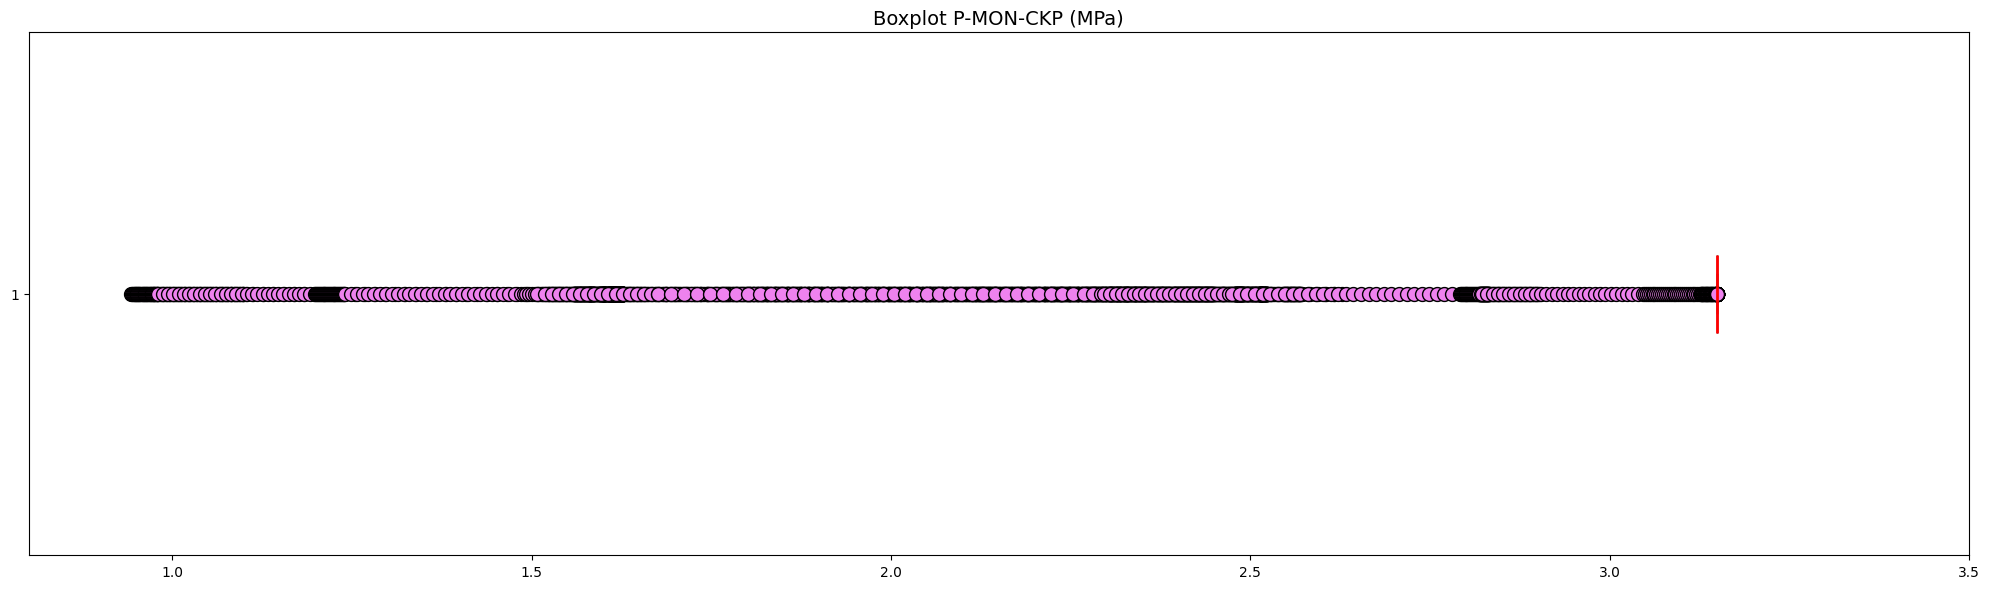

In [73]:
plt.figure(figsize=(20, 6))  # Ajustar tamaño de la figura si es necesario

# Definir propiedades para los outliers
flierprops = dict(marker='o', markerfacecolor='violet', markersize=10, linestyle='none', markeredgecolor='black')

boxplot_parts = plt.boxplot(df_well_20["P-MON-CKP (MPa)"], vert=False, flierprops=flierprops, patch_artist=True)

# Estilos para la caja, bigotes y mediana (como antes)
boxplot_parts['boxes'][0].set(facecolor='skyblue', edgecolor='black')
for whisker in boxplot_parts['whiskers']:
    whisker.set(color='gray')
for median in boxplot_parts['medians']:
    median.set(color='red', linewidth=2)

plt.title('Boxplot P-MON-CKP (MPa)', fontsize=14)
# plt.yticks([])  # Ocultar ticks del eje Y

# Ajustar la escala horizontal (eje X)
plt.xlim(0.8, 3.5)  # Ajusta los límites según tus datos

plt.tight_layout()
plt.show()

# Estudio de variables a lo largo del tiempo

En esta sección, se presentan gráficos que muestran la evolución de las variables vistas a lo largo del tiempo para datos simulados y reales de los pozos WELL-00020 y WELL-0021.

El objetivo de esta visualización es analizar la variación de estas variables con el tiempo y evaluar su relación con el evento no deseado de formacion de hidratos. Para ello, se incluye en cada gráfico una segunda curva que representa la variable class, cuyos valores (0, 130 y 3) indican el evento normal (0) o el Faulty Transient (Transitorio Defectuoso 103) o Faulty Steady State (Estado Estable Defectuoso 3).

Esta representación gráfica permitirá identificar tendencias y posibles patrones en los datos, facilitando una interpretación visual de cómo la temperatura y la presión pueden estar asociadas con la formación de hidratos en cada pozo y conjunto de datos simulado.

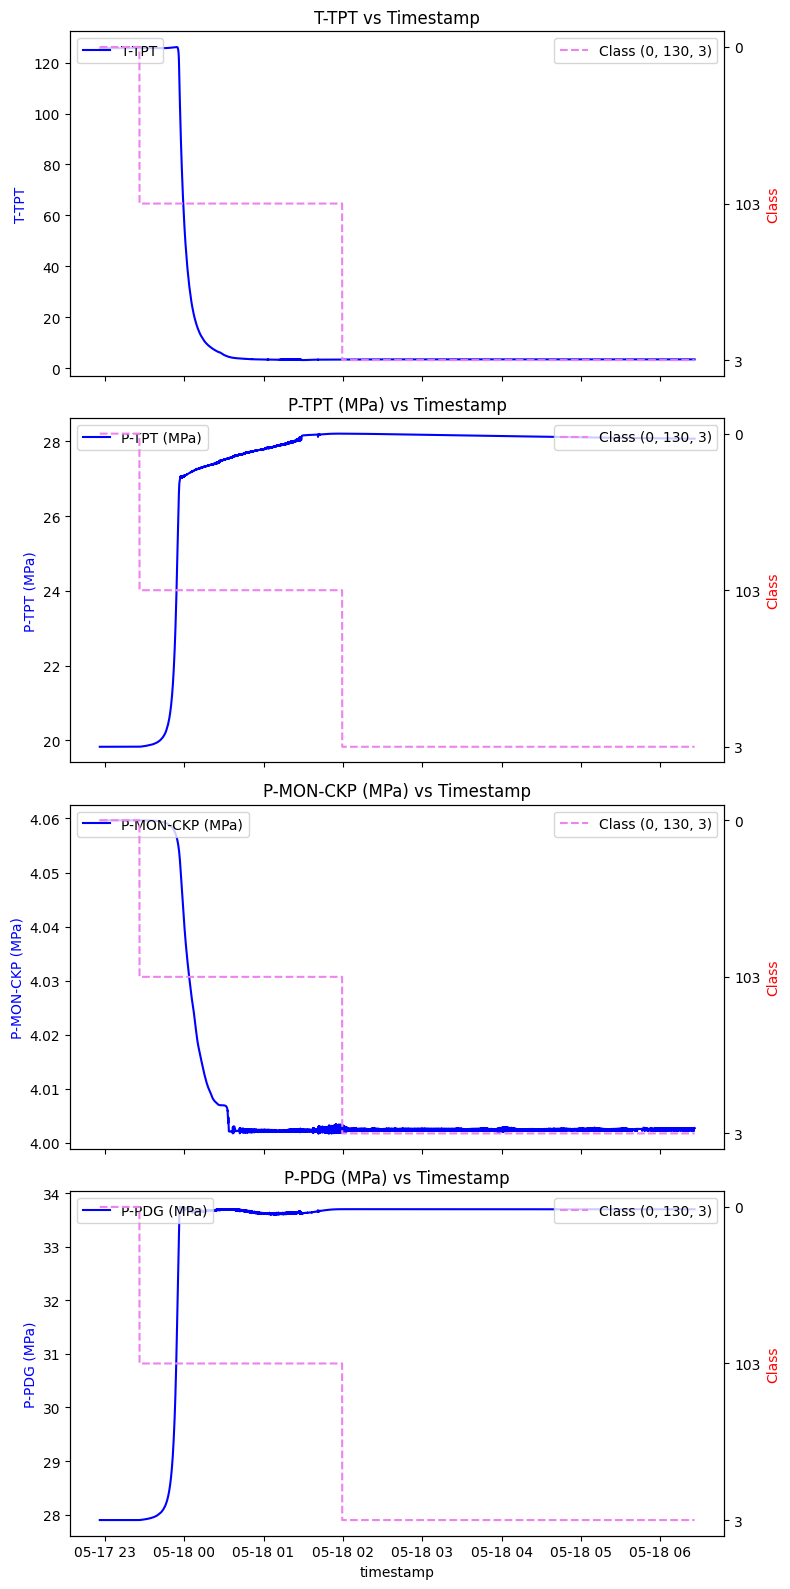

In [74]:
## PRIMER ARCHIVO SIMULADO
import seaborn as sns

# Primer eje Y: Graficar la variable (ejemplo: presión o temperatura)
df_simulated_1["timestamp"] = pd.to_datetime(df_simulated_1["timestamp"])  # Asegurar formato de fecha
df_simulated_1=df_simulated_1.sort_values(by="timestamp") #en el csv se veia ordenado, pero nos aseguramos igual

variables_ejey = ["T-TPT", "P-TPT (MPa)", "P-MON-CKP (MPa)", "T-JUS-CKP", "P-PDG (MPa)"]

fig, axes = plt.subplots(len(variables), 1, figsize=(8, 4 * len(variables)), sharex=True)

for i, var in enumerate(variables):
    ax1 = axes[i]  # Primer eje Y
    sns.lineplot(x=df_simulated_1["timestamp"], y=df_simulated_1[var], ax=ax1, label=var, color="blue")
    ax1.set_ylabel(var, color="blue")

    # Crear segundo eje Y
    ax2 = ax1.twinx()
    sns.lineplot(x=df_simulated_1["timestamp"], y=df_simulated_1["class"], ax=ax2, color="violet", linestyle="dashed", label="Class (0, 130, 3)")
    ax2.set_ylabel("Class", color="red")

    ax1.set_title(f"{var} vs Timestamp")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

plt.xlabel("Timestamp")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Como era de esperarse, la formación no deseada de hidratos se manifiesta claramente en valores bajos de temperatura (T-TPT) y altos de presión en el transductor (P-TPT), en concordancia con las mediciones de presión en el manómetro (P-PDG).

Por otro lado, la presión aguas arriba de la válvula de control de presión (PCK) comienza a disminuir a medida que se produce la formación de hidratos. Este fenómeno puede generar una obstrucción parcial del flujo, incrementando la resistencia al paso del gas y del fluido. Dicha obstrucción provoca una caída de presión aguas arriba de la válvula de producción, ya que el flujo se ve dificultado por la acumulación de cristales de hidrato. Cuando el gas natural entra en contacto con el agua en condiciones de baja temperatura y alta presión, se forman los hidratos, lo que contribuye a la disminución de la presión en la línea de producción.

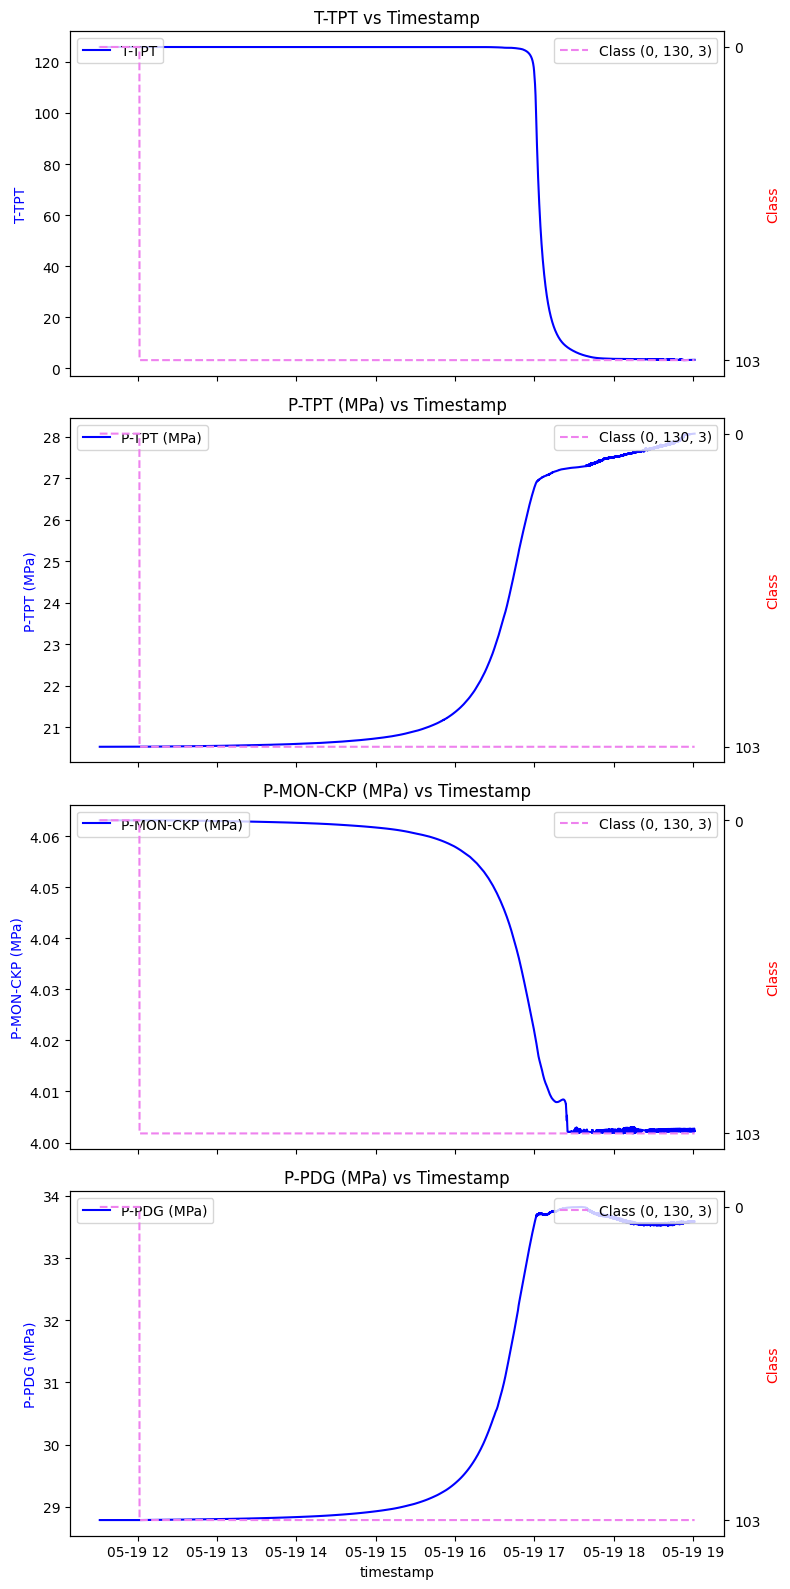

In [75]:
# ULTIMO ARCHIVO SIMULADO
# Primer eje Y: Graficar la variable (ejemplo: presión o temperatura)
file_simulated_81='SIMULATED_00081.csv'
df_simulated_81=dfs[file_simulated_81]

df_simulated_81["timestamp"] = pd.to_datetime(df_simulated_81["timestamp"])  # Asegurar formato de fecha
df_simulated_81=df_simulated_81.sort_values(by="timestamp") #en el csv se veia ordenado, pero nos aseguramos igual

variables_ejey = ["T-TPT", "P-TPT (MPa)", "P-MON-CKP (MPa)", "T-JUS-CKP", "P-PDG (MPa)"]

fig, axes = plt.subplots(len(variables), 1, figsize=(8, 4 * len(variables)), sharex=True)

for i, var in enumerate(variables):
    ax1 = axes[i]  # Primer eje Y
    sns.lineplot(x=df_simulated_81["timestamp"], y=df_simulated_81[var], ax=ax1, label=var, color="blue")
    ax1.set_ylabel(var, color="blue")

    # Crear segundo eje Y
    ax2 = ax1.twinx()
    sns.lineplot(x=df_simulated_81["timestamp"], y=df_simulated_81["class"], ax=ax2, color="violet", linestyle="dashed", label="Class (0, 130, 3)")
    ax2.set_ylabel("Class", color="red")

    ax1.set_title(f"{var} vs Timestamp")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

plt.xlabel("Timestamp")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En el segundo conjunto de datos simulado, el evento 103 se presenta nuevamente a bajas temperaturas en el traductor T-TPT y con valores elevados de presión en P-TPT, en concordancia con los valores de P-PDG. La principal diferencia en este caso es que los valores se mantienen por un período prolongado en niveles altos de T y en valores bajos de P-TPT y P-PDG. Sin embargo, el evento 103 se hace evidente incluso antes de que los valores de T comiencen a descender y los de P aumenten. Es probable que este conjunto de datos corresponda a un momento previo a la formación de hidratos. Dado que se trata de simulaciones, es posible que se esté enfocando en los parámetros previos al evento no deseado, esto es lo que el documento explicativo de los datos llama como períodos transitorios defectuosos.

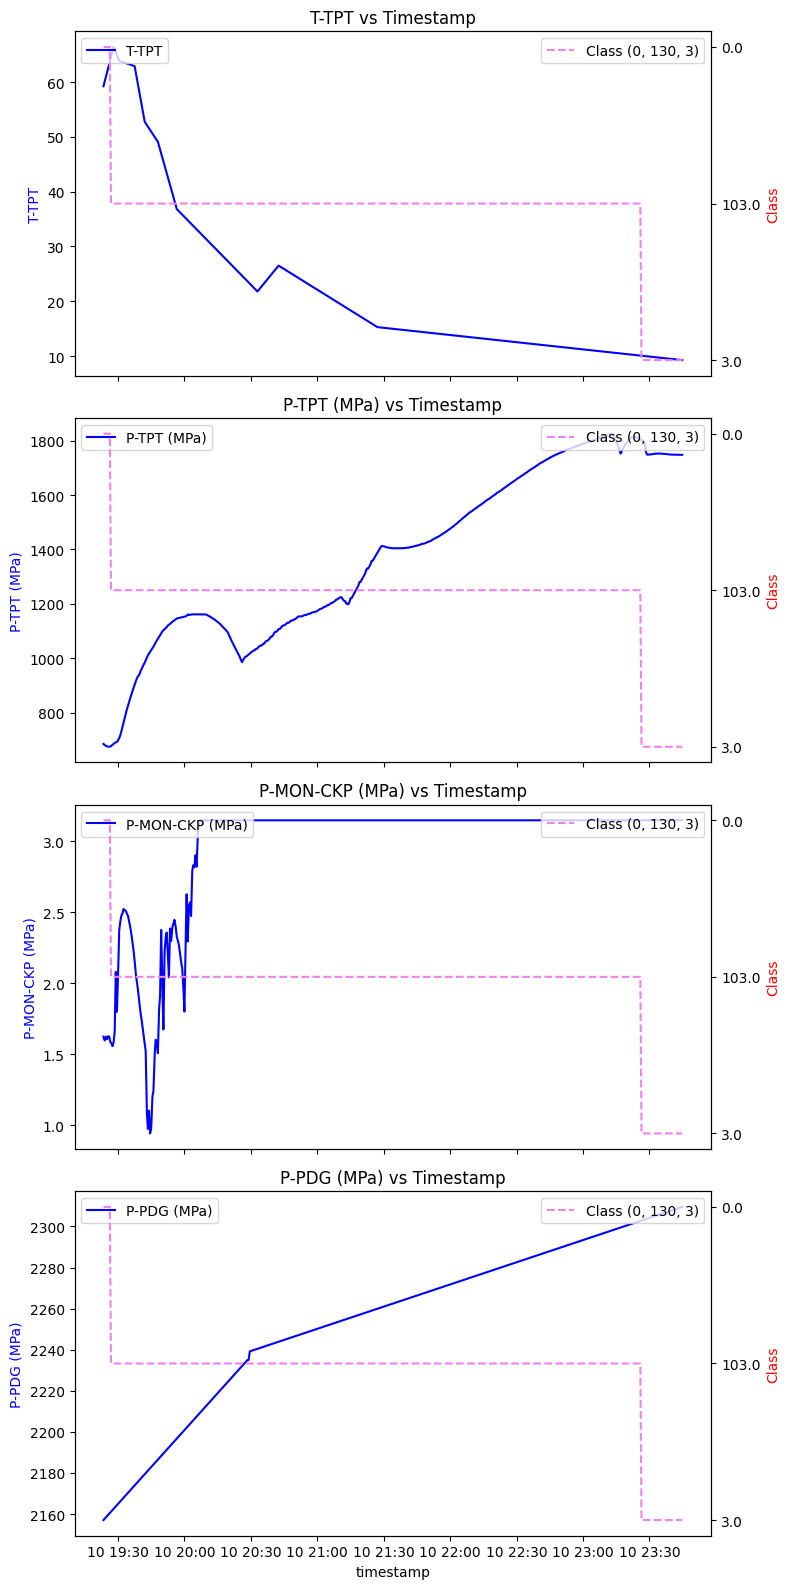

In [76]:
## POZO WELL-00020

# Primer eje Y: Graficar la variable (ejemplo: presión o temperatura)
df_well_20["timestamp"] = pd.to_datetime(df_well_20["timestamp"])  # Asegurar formato de fecha
df_well_20=df_well_20.sort_values(by="timestamp") #en el csv se veia ordenado, pero nos aseguramos igual

##se encontraron NaN en la columna class
# Filtrar las filas donde 'class' es igual a la cadena 'nan' (mas arriba la habia pasado a string)
nan_rows = df_well_20[df_well_20['class'] == 'nan']

# Visualiza los registros completos con NaN en la columna 'class'
# print(nan_rows)
filtered_df_well_20 = df_well_20[df_well_20['class'] != 'nan']

variables_ejey = ["T-TPT", "P-TPT (MPa)", "P-MON-CKP (MPa)", "T-JUS-CKP", "P-PDG (MPa)"]

fig, axes = plt.subplots(len(variables), 1, figsize=(8, 4 * len(variables)), sharex=True)

for i, var in enumerate(variables):
    ax1 = axes[i]  # Primer eje Y
    sns.lineplot(x=df_well_20["timestamp"], y=df_well_20[var], ax=ax1, label=var, color="blue")
    ax1.set_ylabel(var, color="blue")

    # Crear segundo eje Y
    ax2 = ax1.twinx()
    sns.lineplot(x=filtered_df_well_20["timestamp"], y=filtered_df_well_20["class"], ax=ax2, color="violet", linestyle="dashed", label="Class (0, 130, 3)")
    ax2.set_ylabel("Class", color="red")

    ax1.set_title(f"{var} vs Timestamp")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

plt.xlabel("Timestamp")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En este pozo, se observó inicialmente que algunos registros no estaban etiquetados, por lo que se aplicó un filtro para la curva Class exclusivamente, sin filtrar las curvas de las variables en función del tiempo.

En términos generales, los valores mostrados son más realistas, ya que las curvas no presentan un comportamiento exponencial (ni de aumento ni de disminución). En su lugar, se evidencian fluctuaciones al aumentar o disminuir.

Se puede visualizar que el evento de tipo transitorio defectuoso comienza cuando la temperatura en el transductor **T-TPT** baja de +60°C a menos de 40°C. La formación de hidratos finalmente ocurre cuando la temperatura desciende a **10°C**. En relación con la presión en el transductor **P-TPT**, el evento transitorio defectuoso comienza cuando la presión aumenta desde 676 MPa y finalmente se estabiliza en aproximadamente **1800 MPa.**

En cuanto a la presión en el manómetro **P-PDG**, se observa un aumento lineal al principio con una pendiente más pronunciada hasta llegar a 2240 MPa, seguido de una pendiente menor hasta alcanzar los 2300 MPa. Esto explica por qué el histograma mostró dos picos con techos bastante planos. Cuando la presión del pozo supera los **2300 MPa**, el evento de formación de hidratos se estabiliza.

La presión aguas arriba de la válvula de choke de producción P-MON-CKP fluctúa inicialmente, pero luego se mantiene estable en 3 MPa, lo cual difiere de los escenarios simulados, donde la presión aumenta. Esto podria deberse a las condiciones iniciales ya que en los escenarios simulados baja hasta 4MPa y en este caso se estabiliza en 3MPa.

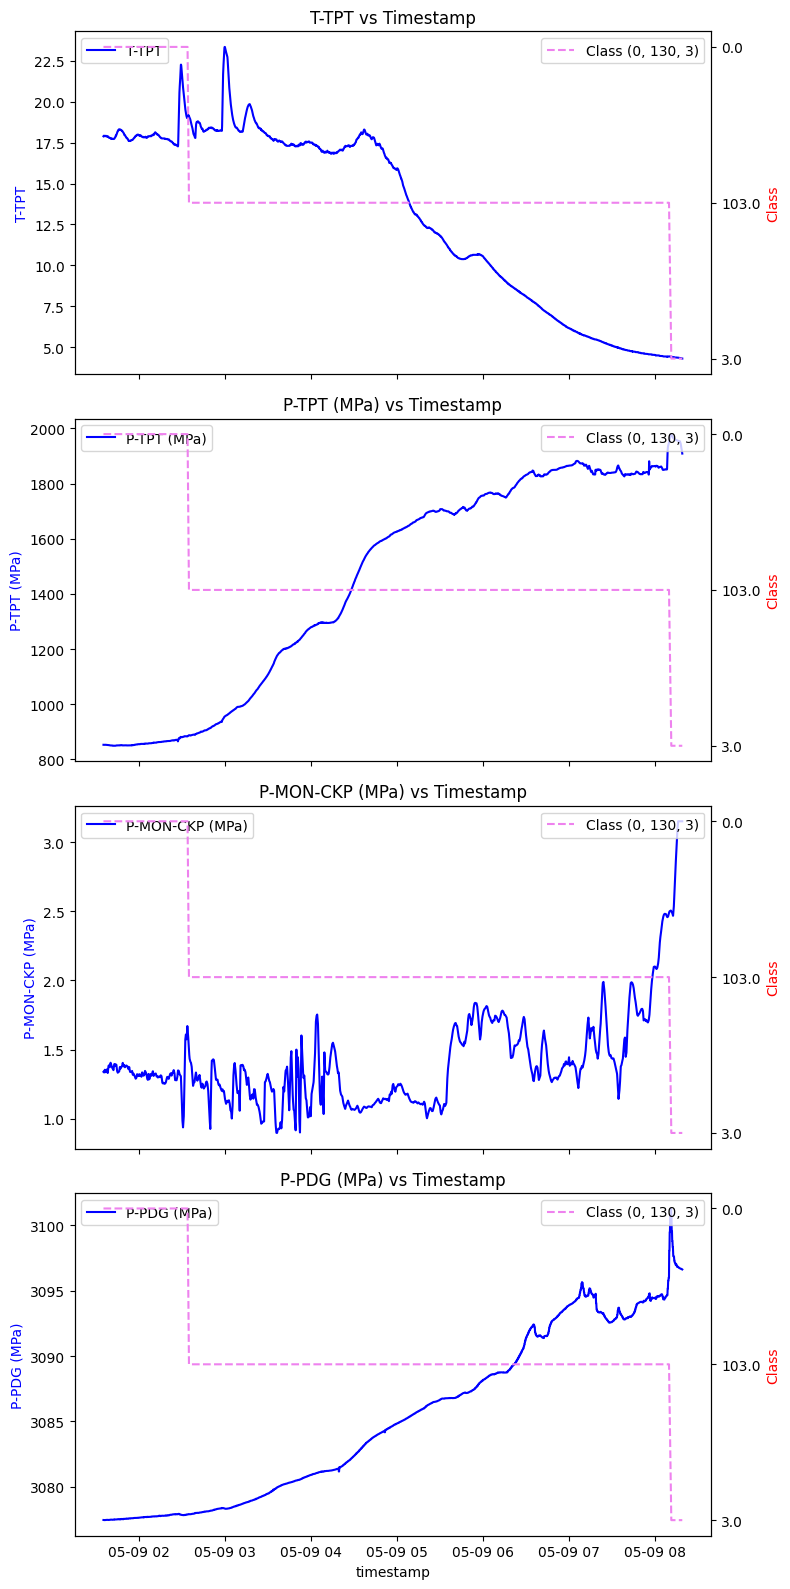

In [78]:
## POZO WELL-00021

# Primer eje Y: Graficar la variable (ejemplo: presión o temperatura)
df_well_21["timestamp"] = pd.to_datetime(df_well_21["timestamp"])  # Asegurar formato de fecha
df_well_21=df_well_21.sort_values(by="timestamp") #en el csv se veia ordenado, pero nos aseguramos igual

##se encontraron NaN en la columna class
# Filtrar las filas donde 'class' es igual a la cadena 'nan' (mas arriba la habia pasado a string)
nan_rows = df_well_21[df_well_21['class'] == 'nan']

# Visualiza los registros completos con NaN en la columna 'class'
# print(nan_rows)
filtered_df_well_21 = df_well_21[df_well_21['class'] != 'nan']

variables_ejey = ["T-TPT", "P-TPT (MPa)", "P-MON-CKP (MPa)", "T-JUS-CKP", "P-PDG (MPa)"]

fig, axes = plt.subplots(len(variables), 1, figsize=(8, 4 * len(variables)), sharex=True)

for i, var in enumerate(variables):
    ax1 = axes[i]  # Primer eje Y
    sns.lineplot(x=df_well_21["timestamp"], y=df_well_21[var], ax=ax1, label=var, color="blue")
    ax1.set_ylabel(var, color="blue")

    # Crear segundo eje Y
    ax2 = ax1.twinx()
    sns.lineplot(x=filtered_df_well_21["timestamp"], y=filtered_df_well_21["class"], ax=ax2, color="violet", linestyle="dashed", label="Class (0, 130, 3)")
    ax2.set_ylabel("Class", color="red")

    ax1.set_title(f"{var} vs Timestamp")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

plt.xlabel("Timestamp")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En el pozo WELL_0021, tanto la temperatura como la presión en el transductor **T-TPT** y **P-TPT** siguen una tendencia similar al pozo WELL_0020 respecto a los eventos transitorios defectuosos y estables defectuosos. La formación de hidratos comienza a establecerse cuando la temperatura alcanza los **5°C** y la presión supera los **1800 MPa.**

La presión de fondo del pozo **P-PDG** muestra un aumento gradual, y el evento de formación de hidratos se produce a presiones superiores a **3095 MPa.**

En cuanto a la presión aguas arriba de la válvula de choke de producción P-MON-CKP, se observa un comportamiento similar al del pozo anterior. Comienza con un valor inicial de 1.4 MPa, presenta fluctuaciones durante los eventos transitorios defectuosos, y durante la formación estable de hidratos, la presión aumenta hasta alcanzar los 3 MPa.



# Conclusión General del analisis de datos

El análisis de los datos de temperatura (T-TPT) y presión (P-TPT) en los eventos de formación de hidratos ha permitido identificar patrones y diferencias significativas tanto en los pozos reales como en los datos simulados. En los pozos reales, los eventos de formación de hidratos se inician cuando la temperatura en el transductor baja por debajo de un umbral crítico, generalmente alrededor de los 10/5°C en datos reales y 3°C en datos simulados, y las presiones superan los 1800 MPa en casos reales y 28 MPa en escenarios simulados.  Esta discrepancia podria deberse a que los datos simulados han sido generados bajo condiciones más controladas y dentro de rangos operativos definidos, mientras que los datos reales reflejan la variabilidad de los pozos en operación, incluyendo condiciones extremas que pueden presentarse en la industria.

La formación de hidratos en pozos reales tambien depende en gran medida de la cantidad de agua presente en la corriente de gas, así como de la composición de los hidrocarburos, que influye en la temperatura y presión a las cuales los hidratos pueden formarse. En pozos con mayor contenido de agua o hidrocarburos más pesados, la formación de hidratos puede ocurrir a presiones más bajas o temperaturas más altas, mientras que en sistemas con menos agua o hidrocarburos más ligeros, los hidratos pueden formarse en condiciones más estrictas de temperatura y presión.

En cuanto a los datos simulados, estos muestran una mayor consistencia y previsibilidad en los eventos de formación de hidratos, lo cual es una característica común de las simulaciones numéricas. Sin embargo, estos datos a menudo no reflejan completamente las variaciones y complejidades presentes en los pozos reales, como las fluctuaciones en las presiones o las posibles interacciones no modeladas entre los diferentes componentes del sistema (agua, gas, hidrocarburos). Las simulaciones tienden a seguir patrones más uniformes, lo que puede no capturar completamente la heterogeneidad observada en el entorno operativo real.

En resumen, mientras que los datos de pozos reales muestran una variabilidad inherente a las condiciones del campo, los datos simulados proporcionan una referencia más estable y predecible. La diferencia en los valores entre ambos conjuntos de datos se puede atribuir a factores como la composición del gas, el contenido de agua y las condiciones operacionales de los pozos, lo que hace que las simulaciones sean una herramienta valiosa para la predicción y el análisis.
